# Section 1: Dataset Selection & Cleaning

In [ ]:
from google.colab import drive
import pandas as pd
import json

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/MKA_Advance_NLP/1st_Assignment/IndoNewsCorpus_Dataset/november.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           sumber     tanggal        kategori  \
0  tribunnews.com  2015/11/01  Bisnis Ekonomi   
1  tribunnews.com  2015/11/01  Bisnis Ekonomi   
2  tribunnews.com  2015/11/01  Bisnis Ekonomi   
3  tribunnews.com  2015/11/01  Bisnis Ekonomi   
4  tribunnews.com  2015/11/01  Bisnis Ekonomi   

                                               judul  \
0  Anggota DPR: Kenapa BUMN Diberi Subsidi Rakyat...   
1  DPR Bingung Anggaran Subsidi Listrik Rp 38 Tri...   
2  Jatah Subsidi Listrik Berkurang Picu Kecemburu...   
3  Migrasi Penggunaan Daya Listrik Dinilai Bisa B...   
4  Citi Indonesia Merevolusi Pengalaman Perbankan...   

                                                 isi  \
0  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...   
1  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...   
2  TRIBUNNEWS.COM, JAKARTA - Pengamat Ekonomi dar...   
3  TRIBUNNEWS.C

In [ ]:
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')

indonesian_stopwords = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    return ' '.join(tokens)

# Apply preprocessing to the 'isi' column (article content)
df['cleaned_isi'] = df['isi'].apply(preprocess_text)

# Split into training (70%), validation (10%), and test (20%) sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_isi'], df['kategori'], test_size=0.3, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, random_state=42)  # Split remaining 30% into 10% and 20%

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training set size: 16934
Validation set size: 2419
Test set size: 4839


# Section 2: Methods

## 2.1 LSTM + FastText


1. Install Required Libraries

In [ ]:
!pip install flair tensorflow==2.12 --quiet

2. Load Pre-trained FastText Embeddings

In [ ]:
import torch
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings
from flair.data import Sentence
import numpy as np

torch.set_default_tensor_type('torch.FloatTensor')

# Load pre-trained FastText embeddings via Flair
fasttext_embedding = WordEmbeddings('id')  # 'id' is for Indonesian FastText embeddings
document_embeddings = DocumentPoolEmbeddings([fasttext_embedding])

# Function to generate document embeddings for a list of texts
def generate_flair_embeddings(texts):
    embeddings = []
    for text in texts:
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        embeddings.append(sentence.get_embedding().cpu().numpy())
    return np.array(embeddings)

X_train_flair = generate_flair_embeddings(train_texts)
X_val_flair = generate_flair_embeddings(val_texts)
X_test_flair = generate_flair_embeddings(test_texts)

print(f"Train embeddings shape: {len(X_train_flair)}")
print(f"Validation embeddings shape: {len(X_val_flair)}")
print(f"Test embeddings shape: {len(X_test_flair)}")

Train embeddings shape: 16934
Validation embeddings shape: 2419
Test embeddings shape: 4839


3. Build and Compile the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

X_train_flair = X_train_flair.reshape(X_train_flair.shape[0], 1, X_train_flair.shape[1])

model = Sequential([
    Input(shape=(X_train_flair.shape[1], X_train_flair.shape[2])),
    LSTM(128, return_sequences=True, recurrent_activation='sigmoid'),
    Dropout(0.5),
    LSTM(64, return_sequences=False, recurrent_activation='sigmoid'),
    Dropout(0.5),
    Dense(len(set(train_labels)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            219648    
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 269,576
Trainable params: 269,576
Non-trainable params: 0
_________________________________________________________________
None


4. Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Reshape X_val_flair and X_test_flair to match X_train_flair
X_val_flair = X_val_flair.reshape(X_val_flair.shape[0], 1, X_val_flair.shape[1])
X_test_flair = X_test_flair.reshape(X_test_flair.shape[0], 1, X_test_flair.shape[1])

# Train the model with early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_FastText = model.fit(
    X_train_flair,
    train_labels_encoded,
    validation_data=(X_val_flair, val_labels_encoded),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
530/530 [==============================] - 8s 7ms/step - loss: 0.7579 - accuracy: 0.7473 - val_loss: 0.4142 - val_accuracy: 0.8640
Epoch 2/10
530/530 [==============================] - 3s 5ms/step - loss: 0.4184 - accuracy: 0.8643 - val_loss: 0.3559 - val_accuracy: 0.8768
Epoch 3/10
530/530 [==============================] - 3s 5ms/step - loss: 0.3685 - accuracy: 0.8774 - val_loss: 0.3298 - val_accuracy: 0.8871
Epoch 4/10
530/530 [==============================] - 3s 5ms/step - loss: 0.3476 - accuracy: 0.8853 - val_loss: 0.3268 - val_accuracy: 0.8855
Epoch 5/10
530/530 [==============================] - 3s 5ms/step - loss: 0.3352 - accuracy: 0.8876 - val_loss: 0.3394 - val_accuracy: 0.8818
Epoch 6/10
530/530 [==============================] - 3s 5ms/step - loss: 0.3256 - accuracy: 0.8919 - val_loss: 0.3315 - val_accuracy: 0.8892
Epoch 7/10
530/530 [==============================] - 3s 5ms/step - loss: 0.3169 - accuracy: 0.8941 - val_loss: 0.3171 - val_accuracy: 0.8896
Epoch 

5. Evaluate the Model and Generate Metrics

152/152 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       773
           1       0.97      1.00      0.99       686
           2       0.84      0.61      0.70       196
           3       0.91      0.96      0.93      2371
           4       0.97      0.88      0.93       274
           5       0.90      0.91      0.91       154
           6       0.86      0.84      0.85       236
           7       0.79      0.79      0.79       149

    accuracy                           0.91      4839
   macro avg       0.89      0.85      0.86      4839
weighted avg       0.90      0.91      0.90      4839



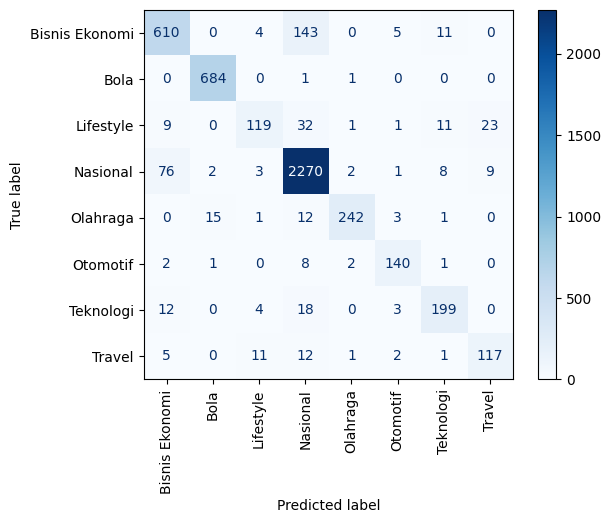

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_predictions = model.predict(X_test_flair).argmax(axis=1)

print("Classification Report:")
print(classification_report(test_labels_encoded, test_predictions))

conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation='vertical')